In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
gpu_config = {
    "seed": 42,
    "device": "cuda",
}

In [4]:
from omegaconf import OmegaConf

gpu_config = OmegaConf.create(gpu_config)

In [5]:
import torch
import numpy as np

torch.manual_seed(gpu_config.seed)
np.random.seed(gpu_config.seed)

if torch.cuda.is_available and 'cuda' in gpu_config.device:
    torch.cuda.manual_seed(gpu_config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

os.environ['PYTHONASHSEED'] = str(gpu_config.seed)

In [6]:
dataloader_cfg = {
    "datasets": {
        "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
        "ratio_val": 0.1,
        "random_val": False,
        "extend_data": True,
        "sample_duration": 2.0,
        "remove_segments_inactive": False,
        "p_drop": 0.0,
        "p_insert": 0.0,
        "jitter_sigma": 0.0,
        "dtype": "float32",
        "dt": 4e-3,
    }
}

In [7]:
dataloader_cfg = OmegaConf.create(dataloader_cfg)

In [8]:
dtype = getattr(torch, dataloader_cfg.datasets.dtype)

In [9]:
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [10]:
monkey_name = "indy"
monkey_files = {
    "indy": {
        "session01": "indy_20160622_01.mat",
        "session02": "indy_20160624_03.mat"
    }
}

In [11]:
filename = list(monkey_files[monkey_name].values())
filename

['indy_20160622_01.mat', 'indy_20160624_03.mat']

In [12]:
train_data, val_data, test_data = dataloader.get_multiple_sessions_data(filename)

Loading indy_20160622_01.mat
[2025-05-27 19:20:40] [INFO] [data.neurobench.dataloader] - Extending data...
Loading indy_20160624_03.mat
[2025-05-27 19:21:06] [INFO] [data.neurobench.dataloader] - Extending data...


In [13]:
print(f"Length of train data: {len(train_data)}")
print(f"Length of val data: {len(val_data)}")
print(f"Length of test data: {len(test_data)}")
print(f"Dimension of 1st spike train data: {(train_data[0][0].shape)}")
print(f"Dimension of 1st of label train data: {(train_data[0][1].shape)}")
print(f"Dimension of 1st spike val data: {(val_data[0][0].shape)}")
print(f"Dimension of 1st of label val data: {(val_data[0][1].shape)}")
print(f"Dimension of 1st spike test data: {(test_data[0][0][0].shape)}")
print(f"Dimension of 1st of label test data: {(test_data[0][0][1].shape)}")

Length of train data: 4722
Length of val data: 974
Length of test data: 2
Dimension of 1st spike train data: torch.Size([500, 96])
Dimension of 1st of label train data: torch.Size([500, 2])
Dimension of 1st spike val data: torch.Size([500, 96])
Dimension of 1st of label val data: torch.Size([500, 2])
Dimension of 1st spike test data: torch.Size([132745, 96])
Dimension of 1st of label test data: torch.Size([132745, 2])


In [14]:
print(f"Data type of 1st spike train data: {train_data[0][0].dtype}")
print(f"Data type of 1st label train data: {train_data[0][1].dtype}")
print(f"Data type of 1st spike val data: {val_data[0][0].dtype}")
print(f"Data type of 1st label val data: {val_data[0][1].dtype}")
print(f"Data type of 1st spike test data: {test_data[0][0][0].dtype}")
print(f"Data type of 1st label test data: {test_data[0][0][1].dtype}")

Data type of 1st spike train data: torch.float32
Data type of 1st label train data: torch.float32
Data type of 1st spike val data: torch.float32
Data type of 1st label val data: torch.float32
Data type of 1st spike test data: torch.float32
Data type of 1st label test data: torch.float32


In [15]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of GPUs: 2
GPU 0: Tesla P100-PCIE-16GB
GPU 1: Tesla P100-PCIE-16GB


In [16]:
nb_time_steps = int(dataloader_cfg.datasets.sample_duration / dataloader_cfg.datasets.dt)

nb_time_steps

500

In [17]:
nb_outputs = train_data[0][1].shape[1]

nb_outputs

2

In [18]:
nb_inputs = train_data[0][0].shape[1]

nb_inputs

96

In [19]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}

In [20]:
training_config = OmegaConf.create(training_config)

In [21]:
device = "cuda:0"

In [22]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn import BaselineRecurrentSpikingModel

model = BaselineRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
)

In [23]:
model.summary()


# Model summary

## Groups

## Connections


In [24]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True
    }
}

In [25]:
model_config = OmegaConf.create(model_config)

In [26]:
# this is the get activation one
import stork

activation_function = stork.activations.CustomSpike

In [27]:
if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

In [28]:
activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

In [29]:
regs = []

regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)

regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)

regs.append(regLB)
regs.append(regUB)

In [30]:
regs

In [31]:
from efficient_rsnn_bmi.core.dataloader import compute_input_firing_rates

mean1, mean2 = compute_input_firing_rates(train_data, dataloader_cfg)
print(mean1, mean2)

torch.Size([500, 96])
tensor(18.8590) None


In [32]:
initializers_config = {
    "initializer": {
        "compute_nu": True,
        "sigma_u": 0.5,
        "nu": 20,
        "alpha": 0.9,
        "kaiming_gain": 1.0
    }
}

In [33]:
initializers_config = OmegaConf.create(initializers_config)

In [34]:
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer
)

hidden_init = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=initializers_config.initializer.sigma_u,
    nu=mean1,
    timestep=dataloader_cfg.datasets.dt,
    alpha=initializers_config.initializer.alpha,
    dtype=dtype,
)

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [35]:
from stork.nodes import InputGroup
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

input_group = model.add_group(
    InputGroup(
       shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)
current_src_grp = input_group
for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales,
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse,
        },
    )

    current_src_grp = hidden_layer.output_group
    print(current_src_grp)

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_data is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    print("Readout group shape: ", readout_group.shape)
    print("Current source group shape: ", current_src_grp.shape)
    print(current_src_grp, readout_group)
    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)
Readout group shape:  (2,)
Current source group shape:  (64,)
CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
) CustomReadoutGroup()


In [36]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


In [37]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError

loss_class = RootMeanSquareError()
# Mask Early Timestep later

In [38]:
from stork.optimizers import SMORMS3

opt_kwargs = {
    "lr": 2e-3
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3

In [39]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

In [40]:
# Make sure this later (Worker Init Seeding)

import numpy as np
import random

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

In [41]:
from stork.generators import StandardGenerator

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

In [42]:
model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.datasets.dt,
)

In [43]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


In [44]:
from datetime import datetime
from pathlib import Path

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

This is the score [ 0.28517597  0.1330028   0.0125     -0.221      -0.10425   ]


/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:249: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


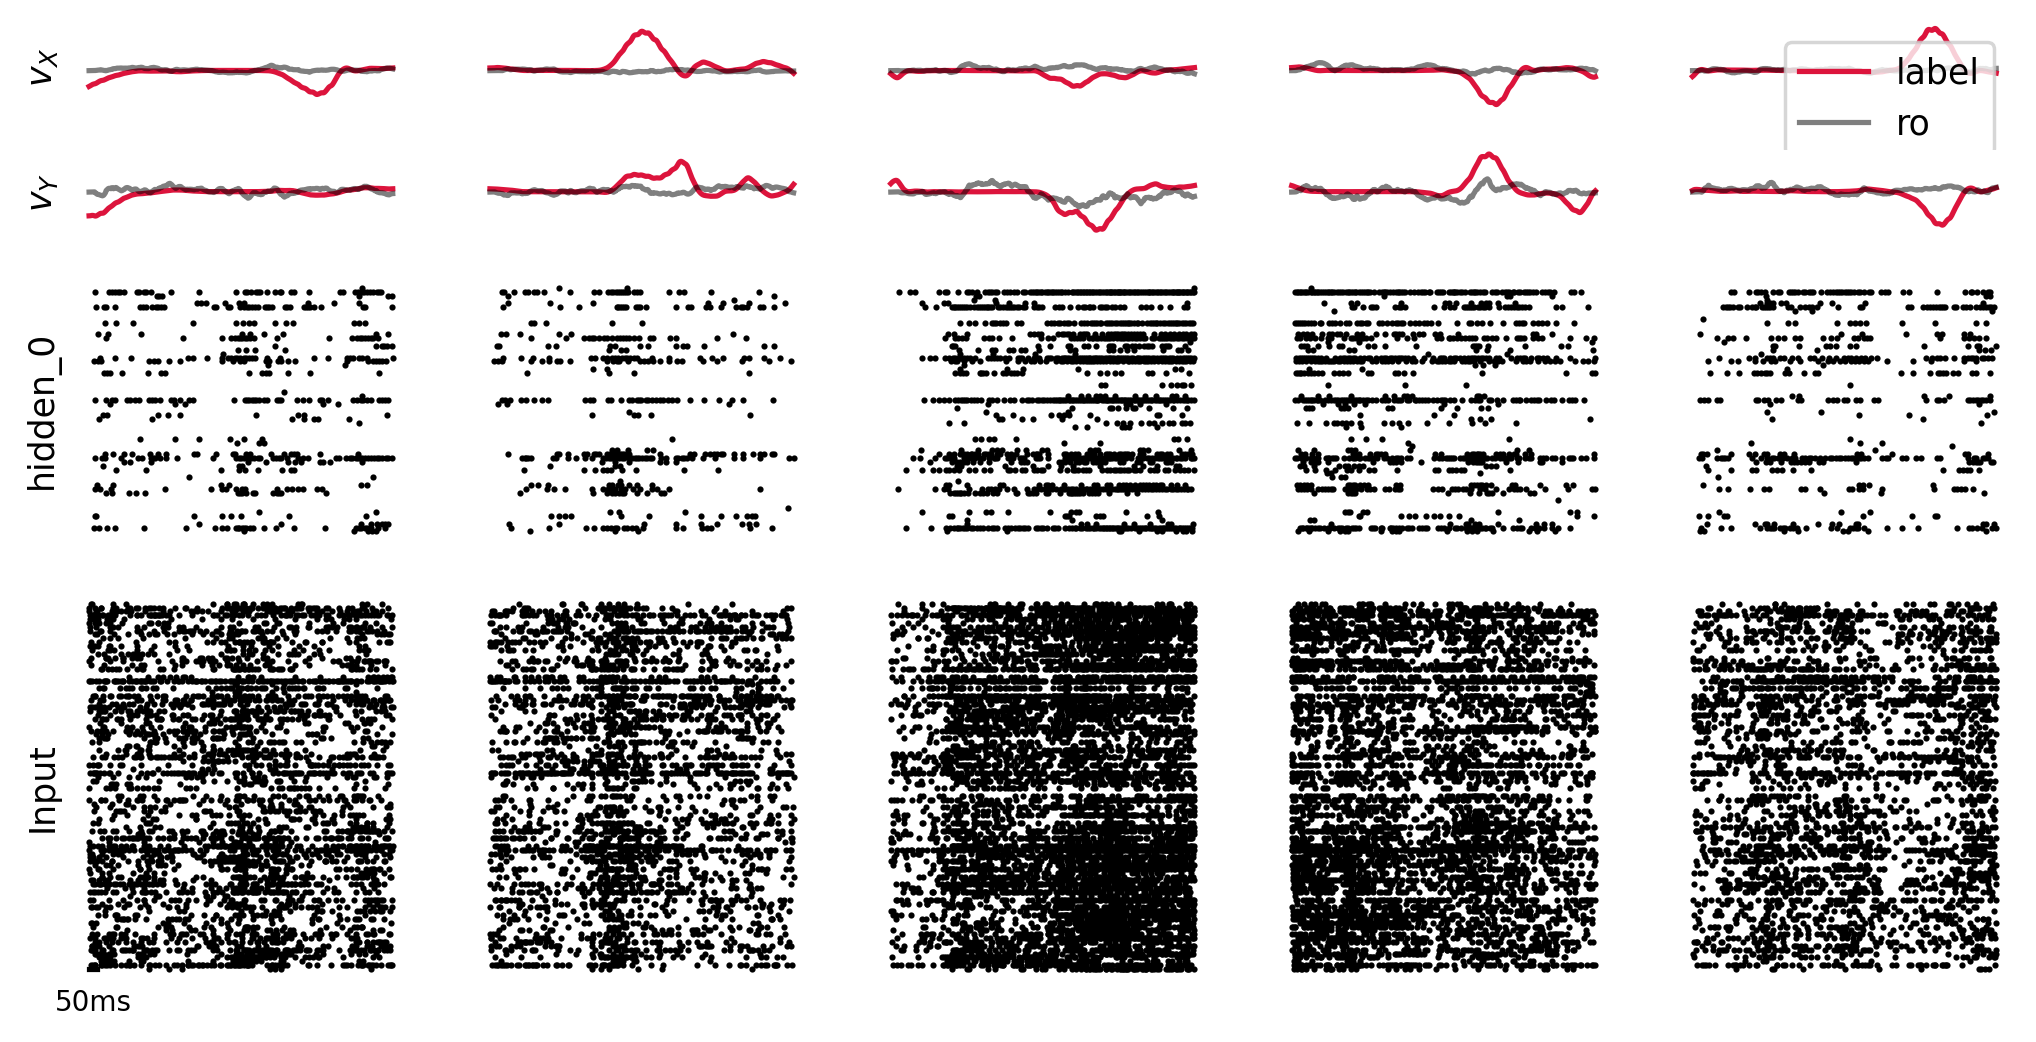

In [45]:
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

In [46]:
history = model.fit_validate(
    train_data,
    val_data,
    nb_epochs=5,
    verbose=True
)

00  loss=0.239 reg_loss=0.0316 r2x=-0.00684 r2y=-0.257 r2=-0.132 -- val_loss=0.266 val_reg_loss=2.38e-05 val_r2x=0.11 val_r2y=0.0323 val_r2=0.0707 t_iter=22.41
01  loss=0.216 reg_loss=0.00239 r2x=0.152 r2y=0.0504 r2=0.101 -- val_loss=0.24 val_reg_loss=1.26e-05 val_r2x=0.269 val_r2y=0.225 val_r2=0.248 t_iter=22.02
02  loss=0.202 reg_loss=0.0017 r2x=0.255 r2y=0.193 r2=0.224 -- val_loss=0.231 val_reg_loss=1.15e-05 val_r2x=0.318 val_r2y=0.31 val_r2=0.314 t_iter=21.39
03  loss=0.194 reg_loss=0.00126 r2x=0.304 r2y=0.271 r2=0.287 -- val_loss=0.218 val_reg_loss=8.74e-06 val_r2x=0.391 val_r2y=0.382 val_r2=0.387 t_iter=20.97
04  loss=0.189 reg_loss=0.00118 r2x=0.334 r2y=0.32 r2=0.327 -- val_loss=0.213 val_reg_loss=8.1e-06 val_r2x=0.415 val_r2y=0.428 val_r2=0.421 t_iter=22.13


In [47]:
history

{'loss': array([0.23894688, 0.21599746, 0.20157518, 0.19384206, 0.18900313]),
 'reg_loss': array([0.03161402, 0.00239318, 0.00170021, 0.00126253, 0.00118191]),
 'r2x': array([-0.00684211,  0.15152632,  0.25526316,  0.30368421,  0.33405263]),
 'r2y': array([-0.25721052,  0.05036842,  0.19257894,  0.27126316,  0.32010526]),
 'r2': array([-0.1318421 ,  0.10105263,  0.224     ,  0.28742106,  0.32715789]),
 'val_loss': array([0.2660231 , 0.24013098, 0.23068215, 0.21793889, 0.21267087]),
 'val_reg_loss': array([2.38460016e-05, 1.26169525e-05, 1.15415903e-05, 8.73924512e-06,
        8.09560720e-06]),
 'val_r2x': array([0.10975   , 0.2695    , 0.3175    , 0.39125   , 0.41474999]),
 'val_r2y': array([0.03225, 0.225  , 0.31025, 0.38175, 0.428  ]),
 'val_r2': array([0.07075   , 0.2475    , 0.31425001, 0.38675001, 0.42125   ])}

In [48]:
import torch
import numpy as np
import json

def to_serializable(val):
    if isinstance(val, torch.Tensor):
        return val.item() if val.numel() == 1 else val.tolist()
    elif isinstance(val, np.ndarray):
        return val.tolist()
    elif isinstance(val, (np.floating, np.integer)):
        return val.item()
    elif isinstance(val, dict):
        return {k: to_serializable(v) for k, v in val.items()}
    elif isinstance(val, list):
        return [to_serializable(v) for v in val]
    else:
        return val

In [49]:
serializable_history = to_serializable(history)

with open("training_early_5epoch_result.json", "w") as f:
    json.dump(serializable_history, f, indent=2)

In [ ]:
import json

def fit_in_background():
    global history
    

    with open("history_dump.json", "w") as f:
        json.dump(history, f, indent=2)
    
    print(history)

In [49]:
from threading import Thread

thread = Thread(target=fit_in_background)
thread.start()

00  loss=0.216 reg_loss=0.00239 r2x=0.152 r2y=0.0504 r2=0.101 -- val_loss=0.24 val_reg_loss=1.26e-05 val_r2x=0.269 val_r2y=0.225 val_r2=0.248 t_iter=19.10


Exception in thread Thread-11 (fit_in_background):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/cc/efficient-rsnn-bmi/venvs/efficient-rsnn-bmi/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_363660/1968814273.py", line 5, in fit_in_background
  File "/home/cc/efficient-rsnn-bmi/venvs/efficient-rsnn-bmi/lib/python3.12/site-packages/stork/models.py", line 438, in fit_validate
    ret_train = self.train_epoch(dataset)
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cc/efficient-rsnn-bmi/venvs/efficient-rsnn-bmi/lib/python3.12/site-packages/stork/models.py", line 337, in train_epoch
    output = self.forward_pass(local_X, cur_batch_size=len(local_X))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [50]:
print(history.keys())
print(history)

dict_keys(['loss', 'reg_loss', 'r2x', 'r2y', 'r2', 'val_loss', 'val_reg_loss', 'val_r2x', 'val_r2y', 'val_r2'])
{'loss': array([0.23894688]), 'reg_loss': array([0.03161402]), 'r2x': array([-0.00684211]), 'r2y': array([-0.25721052]), 'r2': array([-0.1318421]), 'val_loss': array([0.2660231]), 'val_reg_loss': array([2.38460016e-05]), 'val_r2x': array([0.10975]), 'val_r2y': array([0.03225]), 'val_r2': array([0.07075])}


In [51]:
submetrics = ["x", "y"]
names = ["loss", "reg_loss", "r2"]

In [52]:
rows = len(submetrics) if any(n != "loss" for n in names) else 1
cols = len(names)

print(f"rows: {rows}")
print(f"cols: {cols}")

rows: 2
cols: 3


/tmp/ipykernel_363660/1075532642.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend()


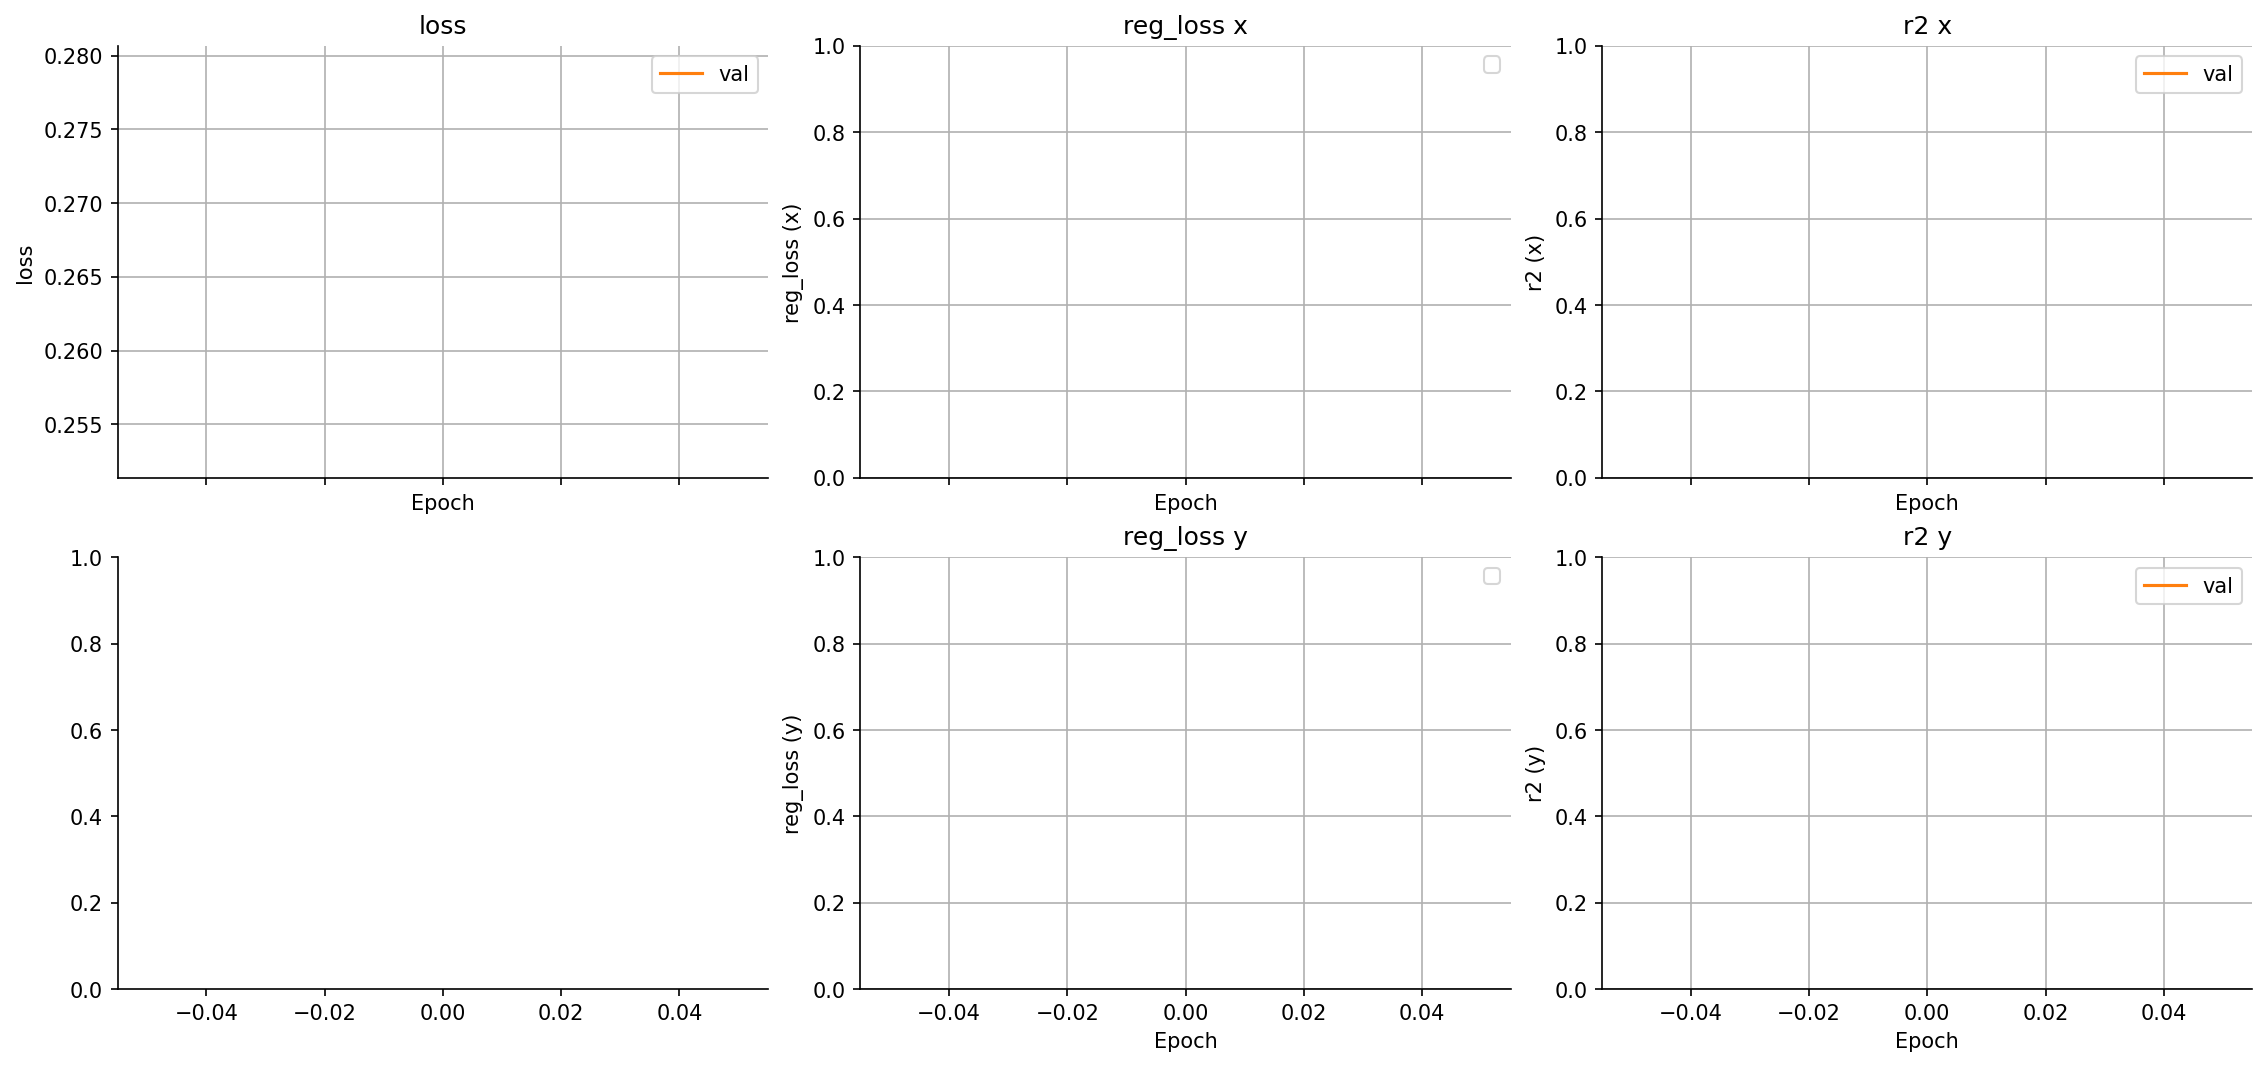

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(
    rows,
    cols,
    figsize = (5 * cols, 3.5 * rows),
    dpi = 150,
    sharex=True,
    constrained_layout = True
)

colors = {
    "train": "tab:blue",
    "val": "tab:orange",
    "test": "crimson"
}

for col_idx, name in enumerate(names):
    if name == 'loss':
        a = ax[0][col_idx] if rows > 1 else ax[col_idx]
        for phase in ['train', 'val']:
            key = f"{phase}_{name}"
            if key in history:
                a.plot(history[key], label=phase, color=colors[phase])
        test_key = f"test_{name}"
        if test_key in history:
            a.axhline(history[test_key], color=colors["test"], linestyle="--", label="test")
        a.set_title(name)
        a.set_xlabel("Epoch")
        a.set_ylabel(name)
        a.grid(True)
        a.legend()
    else:
        for row_idx, s in enumerate(submetrics):
            a = ax[row_idx][col_idx] if rows > 1 else ax[col_idx]
            for phase in ["train", "val"]:
                key = f"{phase}_{name}{s}"
                if key in history:
                    a.plot(history[key], label=phase, color=colors[phase])
            test_key = f"test_{name}{s}"
            if test_key in history:
                a.axhline(history[test_key], color=colors["test"], linestyle="--", label="test")
            a.set_title(f"{name} {s}")
            a.set_ylim(0, 1 if "r2" in name else None)
            a.set_xlabel("Epoch")
            a.set_ylabel(f"{name} ({s})")
            a.grid(True)
            a.legend()

sns.despine()

plt.show()

In [54]:
fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_after.png"
)

Evaluating model... torch.Size([500, 96])


RuntimeError: The size of tensor a (500) must match the size of tensor b (244) at non-singleton dimension 1